# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Análisis de grandes volúmenes de datos**

## Tecnológico de Monterrey

## **Actividad 3:**  Aprendizaje supervisado y no supervisado

## Nombre: **Oscar Luis Guadarrama Jiménez** 
## Matricula:  **A01796245**



# **1.Introducción**

En el contexto del análisis de grandes volúmenes de datos, el aprendizaje automático se ha convertido en una herramienta fundamental para extraer conocimiento útil. Esta práctica tiene como objetivo aplicar dos tipos de algoritmos de *Machine Learning* en PySpark: uno de **aprendizaje supervisado** y otro de **aprendizaje no supervisado**, utilizando una muestra representativa del dataset **Lending Club**, el cual contiene información financiera de clientes que solicitaron préstamos.

---

## Aprendizaje Supervisado

El aprendizaje supervisado se refiere a técnicas que aprenden a partir de un conjunto de datos etiquetado, es decir, que incluye una **variable objetivo** conocida (también llamada *label* o *target*). El algoritmo aprende la relación entre las variables predictoras (features) y la etiqueta, con el fin de hacer predicciones sobre datos nuevos o desconocidos.

### Ejemplos de algoritmos supervisados

- **Árboles de Decisión**: construyen un modelo en forma de árbol, donde cada nodo representa una condición sobre una variable, y las hojas una predicción. Son fáciles de interpretar y adecuados para datos estructurados.
  
- **Random Forest**: consiste en la combinación de varios árboles de decisión, generados aleatoriamente, para mejorar la precisión del modelo y reducir el sobreajuste.

- **Multilayer Perceptron**: es un tipo de red neuronal artificial con múltiples capas ocultas. Captura relaciones complejas entre las variables pero requiere más datos y tiempo de entrenamiento.

---

## Aprendizaje No Supervisado

El aprendizaje no supervisado trabaja con datos sin etiquetas. El objetivo es encontrar **estructuras internas**, **agrupamientos** o **relaciones ocultas** entre las observaciones sin que se indique explícitamente qué se debe predecir.

### Ejemplos de algoritmos no supervisados

- **KMeans**: divide el conjunto de datos en *k* grupos (clusters) que comparten características similares. Es ampliamente usado en segmentación de clientes, análisis de comportamiento o agrupamiento de documentos.

- **Gaussian Mixture Model (GMM)**: a diferencia de KMeans que asigna cada punto a un único clúster, GMM calcula la probabilidad de que un punto pertenezca a cada clúster.

- **Power Iteration Clustering (PIC)**: técnica más avanzada basada en grafos, útil en redes complejas o cuando los datos tienen forma de red o conectividad.

---

## Objetivo de la Práctica

Aplicar algoritmos de aprendizaje supervisado y no supervisado mediante PySpark para la resolución de problemas en análisis de datos, fomentando el desarrollo de habilidades prácticas en el manejo y procesamiento eficiente de grandes conjuntos de datos.

## Librerías utilizadas

A continuación, se importan las librerías necesarias para el procesamiento, modelado y evaluación de datos usando PySpark.


In [242]:
# Sesión de Spark
from pyspark.sql import SparkSession

# Transformaciones sobre columnas
from pyspark.sql.functions import col, when, isnan, count,round,regexp_replace, expr, lit, percentile_approx, first,sum
from pyspark.sql import functions as F
from pyspark.sql.functions import col as spark_col

# Preprocesamiento
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline

# Modelos supervisados
from pyspark.ml.classification import RandomForestClassifier

# Modelos no supervisados
from pyspark.ml.clustering import KMeans

# Evaluación
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator

#Visualización y análisis con Pandas y Matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [243]:
spark = SparkSession.builder.appName("LendingClubLoanData").getOrCreate()
spark

# **2.Selección de los datos**



In [244]:
# Cargar el dataset
df = spark.read.option("header", True).option("inferSchema", True).csv("./loan.csv")

# Mostrar las primeras filas
df.show(5)

+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------+----------+--------------+----------+-------------------+--------+-----------+----------+----+----+------------------+------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-------

## **Procesamiento de datos crudos**

En esta sección se realiza la depuración inicial del conjunto de datos. El dataset original cuenta con 145 columnas, muchas de las cuales presentan problemas como:

- Altos porcentajes de valores nulos o ceros
- Redundancia con otras variables
- Columnas irrelevantes o poco explicativas
- Tipos de datos incorrectos
- Fugas de información o riesgo de data leakage

### Objetivos del procesamiento:

1. Reducir la dimensionalidad sin perder información relevante.
2. Preparar las variables para su uso en modelos de machine learning.
3. Asegurar consistencia tipológica entre variables categóricas y numéricas.

### Etapas aplicadas en la depuración:

- Conversión de columnas `string` a tipos numéricos apropiados (`double` o `int`).
- Eliminación de columnas con más de 20% de valores nulos 
- Detección de columnas con un solo valor dominante (sin varianza).
- Remoción de variables redundantes o subsumidas por otras (por ejemplo: `total_bc_limit` vs `tot_hi_cred_lim`).
- Agrupación de categorías infrecuentes en columnas categóricas (como `purpose`).
- Reducción de clases en variables como `loan_status` para simplificación del modelo.

El resultado es un dataset más compacto, consistente y orientado a modelado, conservando únicamente las variables más informativas.

In [245]:
#Número total de columnas al inicio
print(f"Número total de columnas en el dataset original: {len(df.columns)}")

Número total de columnas en el dataset original: 145


In [246]:
# Ver cuántos valores nulos hay por columna 
print("Valores nulos por columna:")
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(truncate=False)


Valores nulos por columna:
+-------+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-------+-----------+----------+-------+-------+-------+-----+--------+----------+----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+--------

In [247]:
tipos_esperados = {
    "loan_amnt": "int",
    "funded_amnt": "int",
    "funded_amnt_inv": "double",
    "term": "string",
    "int_rate": "double",
    "installment": "double",
    "grade": "string",
    "sub_grade": "string",
    "emp_title": "string",
    "emp_length": "string",
    "home_ownership": "string",
    "annual_inc": "double",
    "verification_status": "string",
    "issue_d": "string",
    "loan_status": "string",
    "pymnt_plan": "string",
    "purpose": "string",
    "title": "string",
    "zip_code": "string",
    "addr_state": "string",
    "dti": "double",
    "delinq_2yrs": "int",
    "earliest_cr_line": "int",
    "inq_last_6mths": "int",
    "open_acc": "int",
    "pub_rec": "int",
    "revol_bal": "int",
    "revol_util": "double",
    "total_acc": "int",
    "initial_list_status": "string",
    "out_prncp": "int",
    "out_prncp_inv": "double",
    "total_pymnt": "double",
    "total_pymnt_inv": "double",
    "total_rec_prncp": "double",
    "total_rec_int": "double",
    "total_rec_late_fee": "double",
    "recoveries": "double",
    "collection_recovery_fee": "double",
    "last_pymnt_d": "string",
    "last_pymnt_amnt": "double",
    "last_credit_pull_d": "string",
    "collections_12_mths_ex_med": "int",
    "policy_code": "int",
    "application_type": "string",
    "acc_now_delinq": "int",
    "tot_coll_amt": "int",
    "tot_cur_bal": "int",
    "total_rev_hi_lim": "int",
    "acc_open_past_24mths": "int",
    "avg_cur_bal": "double",
    "bc_open_to_buy": "int",
    "bc_util": "double",
    "chargeoff_within_12_mths": "double",
    "delinq_amnt": "int",
    "mo_sin_old_il_acct": "int",
    "mo_sin_old_rev_tl_op": "int",
    "mo_sin_rcnt_rev_tl_op": "int",
    "mo_sin_rcnt_tl": "int",
    "mort_acc": "int",
    "mths_since_recent_bc": "int",
    "mths_since_recent_inq": "int",
    "num_accts_ever_120_pd": "int",
    "num_actv_bc_tl": "int",
    "num_actv_rev_tl": "int",
    "num_bc_sats": "int",
    "num_bc_tl": "int",
    "num_il_tl": "int",
    "num_op_rev_tl": "int",
    "num_rev_accts": "int",
    "num_rev_tl_bal_gt_0": "int",
    "num_sats": "int",
    "num_tl_120dpd_2m": "int",
    "num_tl_30dpd": "int",
    "num_tl_90g_dpd_24m": "int",
    "num_tl_op_past_12m": "int",
    "pct_tl_nvr_dlq": "double",
    "percent_bc_gt_75": "double",
    "pub_rec_bankruptcies": "int",
    "tax_liens": "int",
    "tot_hi_cred_lim": "int",
    "total_bal_ex_mort": "int",
    "total_bc_limit": "int",
    "total_il_high_credit_limit": "int",
    "hardship_flag": "string",
    "disbursement_method": "string",
    "debt_settlement_flag": "string",
}


In [248]:
# Corrección automática de tipos según tipos_esperados
for columna, tipo_esperado in tipos_esperados.items():
    if columna in dict(df.dtypes):
        tipo_actual = dict(df.dtypes)[columna]
        if tipo_actual != tipo_esperado:
            print(f"Corrigiendo: {columna} de {tipo_actual} a {tipo_esperado}")
            
            # Limpieza de strings si es necesario para convertir a double
            if tipo_esperado == "double" and tipo_actual == "string":
                df = df.withColumn(columna, regexp_replace(col(columna), "[,%$]", "").cast("double"))
            else:
                df = df.withColumn(columna, col(columna).cast(tipo_esperado))


Corrigiendo: annual_inc de string a double
Corrigiendo: dti de string a double
Corrigiendo: delinq_2yrs de string a int
Corrigiendo: earliest_cr_line de string a int
Corrigiendo: inq_last_6mths de string a int
Corrigiendo: open_acc de string a int
Corrigiendo: pub_rec de string a int
Corrigiendo: revol_bal de string a int
Corrigiendo: revol_util de string a double
Corrigiendo: total_acc de string a int
Corrigiendo: out_prncp de string a int
Corrigiendo: out_prncp_inv de string a double
Corrigiendo: total_pymnt de string a double
Corrigiendo: total_pymnt_inv de string a double
Corrigiendo: total_rec_prncp de string a double
Corrigiendo: total_rec_int de string a double
Corrigiendo: total_rec_late_fee de string a double
Corrigiendo: recoveries de string a double
Corrigiendo: collection_recovery_fee de string a double
Corrigiendo: last_pymnt_amnt de string a double
Corrigiendo: collections_12_mths_ex_med de string a int
Corrigiendo: policy_code de string a int
Corrigiendo: acc_now_delinq 

In [249]:
#ELminar columans con el 20% de vlaores nuloso 
# Calcular total de registros
total_rows = df.count()

# Calcular porcentaje de nulos por columna y quedarte con las que tienen menos del 20%
col_porcentaje_nulos = [
   (sum(when((col(c).isNull()) | (col(c) == ''), 1).otherwise(0)) / total_rows).alias(c)
    for c in df.columns
]

# Generar DataFrame con porcentaje de nulos
porcentaje_nulos_df = df.select(col_porcentaje_nulos)
porcentaje_nulos = porcentaje_nulos_df.collect()[0].asDict()

# Filtrar columnas que tienen menos de 20% de nulos
columnas_validas = [k for k, v in porcentaje_nulos.items() if v < 0.2]

# Seleccionar solo las columnas válidas
df = df.select(*columnas_validas)

print(f"Columnas seleccionadas con <20% de nulos: {len(columnas_validas)}")


Columnas seleccionadas con <20% de nulos: 86


In [250]:
# Columnas con más de 10,000 valores únicos de tipo string (texto libre)
columnas_texto_libre = []

for c in df.columns:
    if dict(df.dtypes)[c] == "string" and df.select(c).distinct().count() > 10000:
        columnas_texto_libre.append(c)

print("Columnas con texto libre o muchas categorías únicas:")
print(columnas_texto_libre)


Columnas con texto libre o muchas categorías únicas:
['emp_title', 'title']


In [251]:
df = df.drop(*columnas_texto_libre)

print(f"Columnas eliminadas por texto libre o alta cardinalidad: {len(columnas_texto_libre)}")
print(f"Total de columnas restantes: {len(df.columns)}")


Columnas eliminadas por texto libre o alta cardinalidad: 2
Total de columnas restantes: 84


In [252]:
# Seleccionar solo columnas numéricas del DataFrame
columnas_numericas = [c for c, t in df.dtypes if t in ("double", "int")]

# Convertimos a Pandas una muestra del dataframe para no saturar memoria
df_sample_pd = df.select(columnas_numericas).sample(False, 0.10, seed=1).toPandas()

# Calculamos matriz de correlación absoluta
cor_matrix = df_sample_pd.corr().abs()

columnas_correladas = set()
umbral = 0.999

for i in range(len(cor_matrix.columns)):
    for j in range(i + 1, len(cor_matrix.columns)):
        col1 = cor_matrix.columns[i]
        col2 = cor_matrix.columns[j]
        if cor_matrix.iloc[i, j] > umbral:
            print(f"Alta correlación entre: {col1} y {col2} (r = {cor_matrix.iloc[i, j]:.4f})")
            columnas_correladas.add(col2)  # Podrías quedarte con el primero, y marcar el segundo para eliminar

# Resultado: columnas candidatas a eliminar por redundancia lineal
columnas_correladas = list(columnas_correladas)


Alta correlación entre: loan_amnt y funded_amnt (r = 0.9998)
Alta correlación entre: loan_amnt y funded_amnt_inv (r = 0.9990)
Alta correlación entre: funded_amnt y funded_amnt_inv (r = 0.9993)
Alta correlación entre: out_prncp y out_prncp_inv (r = 1.0000)
Alta correlación entre: total_pymnt y total_pymnt_inv (r = 0.9993)


In [253]:
# Eliminamos columnas por redundancia lineal
df = df.drop(*list(columnas_correladas))
print(f"Columnas eliminadas por redundancia lineal: {len(columnas_correladas)}")
print(f"Total de columnas restantes: {len(df.columns)}")

Columnas eliminadas por redundancia lineal: 4
Total de columnas restantes: 80


In [254]:
# Detectamos columnas categóricas automáticamente (tipo string o categoricas enteras conocidas)
columnas_categoricas = [c for c, t in df.dtypes if t == "string" or "emp_length" in c]
print(f"Columnas categóricas detectadas: {len(columnas_categoricas)}")
print(columnas_categoricas)


Columnas categóricas detectadas: 19
['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'zip_code', 'addr_state', 'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


In [255]:
# Eliminamos columnas por  baja varianza
columnas_baja_varianza = []
umbral = 0.70
total_rows = df.count()

for c in columnas_categoricas:
    top_valor = df.groupBy(c).count().orderBy("count", ascending=False).first()
    if top_valor and (top_valor["count"] / total_rows) >= umbral:
        print(f"{c}: {top_valor['count'] / total_rows:.2%} del dataset tiene '{top_valor[c]}'")
        columnas_baja_varianza.append(c)



term: 71.21% del dataset tiene ' 36 months'
pymnt_plan: 99.97% del dataset tiene 'n'
application_type: 94.65% del dataset tiene 'Individual'
hardship_flag: 99.95% del dataset tiene 'N'
disbursement_method: 96.53% del dataset tiene 'Cash'
debt_settlement_flag: 98.53% del dataset tiene 'N'


In [256]:
df = df.drop(*columnas_baja_varianza)
print(f"Columnas eliminadas por baja varianza: {len(columnas_baja_varianza)}")
print(f"Total de columnas restantes: {len(df.columns)}")

Columnas eliminadas por baja varianza: 6
Total de columnas restantes: 74


In [257]:
# Eliminaipn por fuga de informacion
columnas_fuga_info = [
    "issue_d",             # Fecha del préstamo
    "last_pymnt_d",        # Fecha del último pago
    "last_credit_pull_d",  # Fecha del último análisis de crédito
]
df = df.drop(*columnas_fuga_info)
print(f"Columnas eliminadas por fuga de informacion: {len(columnas_fuga_info)}")
print(f"Total de columnas restantes: {len(df.columns)}")



Columnas eliminadas por fuga de informacion: 3
Total de columnas restantes: 71


In [258]:
# Detectar columnas numéricas 
columnas_numericas = [c for c, t in df.dtypes if t in ["double", "int"]]

# Eliminamos columnas por  baja varianza

umbral = 0.70
total_rows = df.count()
columnas_valor_dominante = []

for c in columnas_numericas:
    valor_mas_frecuente = (
        df.groupBy(c)
        .count()
        .orderBy("count", ascending=False)
        .first()
    )

    if valor_mas_frecuente:
        valor = valor_mas_frecuente[0]  # el valor dominante
        cuenta = valor_mas_frecuente["count"]
        porcentaje = cuenta / total_rows

        if porcentaje >= umbral:
            print(f"{c}: {porcentaje:.2%} de los valores son '{valor}'")
            columnas_valor_dominante.append(c)


delinq_2yrs: 81.34% de los valores son '0'
pub_rec: 84.16% de los valores son '0'
total_rec_late_fee: 96.25% de los valores son '0.0'
recoveries: 92.14% de los valores son '0.0'
collection_recovery_fee: 92.52% de los valores son '0.0'
collections_12_mths_ex_med: 98.33% de los valores son '0'
policy_code: 99.99% de los valores son '1'
acc_now_delinq: 99.60% de los valores son '0'
tot_coll_amt: 82.11% de los valores son '0'
chargeoff_within_12_mths: 99.22% de los valores son '0.0'
delinq_amnt: 99.67% de los valores son '0'
num_accts_ever_120_pd: 74.64% de los valores son '0'
num_tl_120dpd_2m: 93.15% de los valores son '0'
num_tl_30dpd: 96.63% de los valores son '0'
num_tl_90g_dpd_24m: 91.70% de los valores son '0'
pub_rec_bankruptcies: 87.90% de los valores son '0'
tax_liens: 97.13% de los valores son '0'


In [259]:
df = df.drop(*columnas_valor_dominante)
print(f"Columnas eliminadas por tener >70% ceros: {len(columnas_valor_dominante)}")
print(f"Total de columnas restantes: {len(df.columns)}")

Columnas eliminadas por tener >70% ceros: 17
Total de columnas restantes: 54


In [260]:
# Lista de columnas irrelevantes

columnas_irrelevantes = [

     "zip_code", # zip_code: Dato personal, alta cardinalidad, difícil de codificar.
      "addr_state", # addr_state: Redundante con home_ownership; baja capacidad predictiva.
      "sub_grade",# sub_grade: Desglose innecesario de grade (A1, A2...), ya se usa grade.
      "initial_list_status",    # initial_list_status: metadato técnico sin valor predictivo
 ]
# Eliminamos del DataFrame
df = df.drop(*[c for c in columnas_irrelevantes if c in df.columns])

print(f"Columnas eliminadas por irrelevancia justificada: {len(columnas_irrelevantes)}")
print(f"Columnas finales restantes: {len(df.columns)}")


Columnas eliminadas por irrelevancia justificada: 4
Columnas finales restantes: 50


In [261]:
# Lista de columnas que se eliminan por definición técnica o redundancia
columnas_a_eliminar_por_definicion = [
    "bc_open_to_buy",          # Redundante con bc_util (porcentaje de uso vs. crédito disponible)
    "mo_sin_old_il_acct",      # Tiempo desde cuenta a plazo más antigua; técnica, poco explicativa
    "mo_sin_old_rev_tl_op",    # Tiempo desde cuenta revolvente antigua; similar a la anterior
    "mo_sin_rcnt_rev_tl_op",   # Tiempo desde última línea revolvente; se solapa con mo_sin_rcnt_tl
    "mo_sin_rcnt_tl",          # Tiempo desde última cuenta abierta; técnica, poco interpretable
    "num_bc_tl",               # Total de tarjetas de crédito abiertas históricamente; poco diferenciador
    "num_op_rev_tl",           # Líneas revolventes abiertas; similar a num_rev_tl_bal_gt_0
    "num_rev_accts",           # Cuentas revolventes históricas; métrica muy general
    "total_bc_limit"           # Límite total en tarjetas; ya considerado en tot_hi_cred_lim
]

# Eliminar solo si existen en el DataFrame
df = df.drop(*[c for c in columnas_a_eliminar_por_definicion if c in df.columns])

# Reportar cuántas columnas se eliminaron
print(f"Columnas eliminadas por definición: {len(columnas_a_eliminar_por_definicion)}")
print(f"Columnas finales restantes: {len(df.columns)}")


Columnas eliminadas por definición: 9
Columnas finales restantes: 41


In [262]:
columnas_categoricas = [c for c, t in df.dtypes if t == "string"]

for col_name in columnas_categoricas:
    total_distintos = df.select(col_name).distinct().count()
    df.groupBy(col_name).count().orderBy("count", ascending=False).show()
    

+-----+------+
|grade| count|
+-----+------+
|    B|663557|
|    C|650053|
|    A|433027|
|    D|324424|
|    E|135639|
|    F| 41800|
|    G| 12168|
+-----+------+

+----------+------+
|emp_length| count|
+----------+------+
| 10+ years|748005|
|   2 years|203676|
|  < 1 year|189988|
|   3 years|180753|
|    1 year|148403|
|       n/a|146907|
|   5 years|139698|
|   4 years|136605|
|   6 years|102628|
|   7 years| 92695|
|   8 years| 91914|
|   9 years| 79395|
| reactors"|     1|
+----------+------+

+--------------+-------+
|home_ownership|  count|
+--------------+-------+
|      MORTGAGE|1111449|
|          RENT| 894929|
|           OWN| 253057|
|           ANY|    996|
|         OTHER|    182|
|          NONE|     54|
|       2 years|      1|
+--------------+-------+

+-------------------+------+
|verification_status| count|
+-------------------+------+
|    Source Verified|886230|
|       Not Verified|744806|
|           Verified|629631|
|              38000|     1|
+-------------

In [263]:
# Detectar columnas numéricas
columnas_numericas = [c for c, t in df.dtypes if t in ["int", "double"]]

# Usar describe para estadísticas generales
df.select(columnas_numericas).describe().show()


+-------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+--------------------+---------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+--------------------------+
|summary|         loan_amnt|         int_rate|       installment|       annual_inc|               dti|    inq_last_6mths|          open_acc|         revol_bal|        revol_util|         total_acc|        out_prncp|       total_pymnt|  total_rec_prncp|    total_rec_int|   last_pymnt_amnt|       tot_cur_bal|  total_

In [264]:
categorias_frecuentes = ['MORTGAGE','RENT','OWN']
# Reducir categories en 'home_ownership'
df = df.withColumn(
    "home_ownership",
    when(col("home_ownership").isin(categorias_frecuentes), col("home_ownership"))
    .otherwise("OTHER")
)
# Reducir categories en 'purpose'
df = df.withColumn("purpose", when(col("purpose").isin(
    "debt_consolidation", "credit_card"), "debt_related")
    .when(col("purpose").isin("home_improvement", "major_purchase"), "large_expense")
    .when(col("purpose").isin("small_business", "car", "vacation", "house"), "personal_use")
    .when(col("purpose").isin("medical", "wedding", "moving"), "life_event")
    .otherwise("other"))

# Reducir categories en 'loan_status'
df = df.withColumn("loan_status",
    when(col("loan_status").isin("Fully Paid", "Current"), "No_riesgo")
    .when(col("loan_status").isin("Late (16-30 days)", "In Grace Period"), "riesgo_medio")
    .when(col("loan_status").isin(
        "Charged Off", "Default", "Late (31-120 days)",
        "Does not meet the credit policy. Status:Fully Paid",
        "Does not meet the credit policy. Status:Charged Off",
        "Oct-2015", None), "riesgo_alto")
)


In [265]:
columnas_categoricas = [c for c, t in df.dtypes if t == "string"]

for col_name in columnas_categoricas:
    total_distintos = df.select(col_name).distinct().count()
    df.groupBy(col_name).count().orderBy("count", ascending=False).show()
    

+-----+------+
|grade| count|
+-----+------+
|    B|663557|
|    C|650053|
|    A|433027|
|    D|324424|
|    E|135639|
|    F| 41800|
|    G| 12168|
+-----+------+

+----------+------+
|emp_length| count|
+----------+------+
| 10+ years|748005|
|   2 years|203676|
|  < 1 year|189988|
|   3 years|180753|
|    1 year|148403|
|       n/a|146907|
|   5 years|139698|
|   4 years|136605|
|   6 years|102628|
|   7 years| 92695|
|   8 years| 91914|
|   9 years| 79395|
| reactors"|     1|
+----------+------+

+--------------+-------+
|home_ownership|  count|
+--------------+-------+
|      MORTGAGE|1111449|
|          RENT| 894929|
|           OWN| 253057|
|         OTHER|   1233|
+--------------+-------+

+-------------------+------+
|verification_status| count|
+-------------------+------+
|    Source Verified|886230|
|       Not Verified|744806|
|           Verified|629631|
|              38000|     1|
+-------------------+------+

+------------+-------+
| loan_status|  count|
+------------

## **Construcción de la muestra representativa (`muestra_M`)**

Se utilizó el conjunto de datos Lending Club, del cual se extrajo una muestra representativa llamada `muestra_M` a partir de **4 combinaciones específicas de variables categóricas**:

- `purpose`
- `home_ownership`
- `verification_status`

Estas combinaciones fueron seleccionadas por su alta frecuencia y por representar perfiles distintos en términos de riesgo crediticio.

### Combinaciones seleccionadas:
1. debt_related + MORTGAGE + Source Verified  
2. debt_related + RENT + Source Verified  
3. debt_related + MORTGAGE + Not Verified  
4. debt_related + MORTGAGE + Verified

Cada subconjunto fue filtrado del DataFrame original utilizando estas condiciones, y posteriormente unido para formar el conjunto `muestra_M`, el cual servirá como base para el análisis supervisado y no supervisado.


In [266]:
total = df.count()

combinaciones = df.groupBy('purpose', 'home_ownership','verification_status') \
    .count() \
    .withColumnRenamed("count", "frecuencia") \
    .withColumn("probabilidad (%)", round((col("frecuencia") / total) * 100, 2)) \
    .orderBy("frecuencia", ascending=False)

print("Combinaciones posibles:", combinaciones.count())
combinaciones.show(truncate=False)

Combinaciones posibles: 61
+-------------+--------------+-------------------+----------+----------------+
|purpose      |home_ownership|verification_status|frecuencia|probabilidad (%)|
+-------------+--------------+-------------------+----------+----------------+
|debt_related |MORTGAGE      |Source Verified    |325538    |14.4            |
|debt_related |RENT          |Source Verified    |301930    |13.36           |
|debt_related |MORTGAGE      |Not Verified       |283745    |12.55           |
|debt_related |MORTGAGE      |Verified           |263046    |11.64           |
|debt_related |RENT          |Not Verified       |241428    |10.68           |
|debt_related |RENT          |Verified           |189385    |8.38            |
|debt_related |OWN           |Source Verified    |75220     |3.33            |
|debt_related |OWN           |Not Verified       |63639     |2.82            |
|large_expense|MORTGAGE      |Not Verified       |51856     |2.29            |
|debt_related |OWN       

In [267]:
df_part1 = df.filter((df.purpose == "debt_related") & (df.home_ownership == "MORTGAGE") & (df.verification_status == "Source Verified"))
df_part2 = df.filter((df.purpose == "debt_related") & (df.home_ownership == "RENT") & (df.verification_status == "Source Verified"))
df_part3 = df.filter((df.purpose == "debt_related") & (df.home_ownership == "MORTGAGE") & (df.verification_status == "Not Verified"))
df_part4 = df.filter((df.purpose == "debt_related") & (df.home_ownership == "MORTGAGE") & (df.verification_status == "Verified"))

**Aplicar muestreo aleatorio al 10%**

In [268]:
# Muestreo sin reemplazo
sample1 = df_part1.sample(withReplacement=False, fraction=0.1, seed=1)
sample2 = df_part2.sample(withReplacement=False, fraction=0.1, seed=1)
sample3 = df_part3.sample(withReplacement=False, fraction=0.1, seed=1)
sample4 = df_part4.sample(withReplacement=False, fraction=0.1, seed=1)

 **Unir las muestras en una sola: muestra_M**

In [269]:
# Unión de las muestras
muestra_M = sample1.union(sample2).union(sample3).union(sample4)

# Mostrar las primeras filas
muestra_M.show(5)


+---------+--------+-----------+-----+----------+--------------+----------+-------------------+-----------+------------+-----+--------------+--------+---------+----------+---------+---------+-----------+---------------+-------------+---------------+-----------+----------------+--------------------+-----------+-------+--------+--------------------+---------------------+--------------+---------------+-----------+---------+-------------------+--------+------------------+--------------+----------------+---------------+-----------------+--------------------------+
|loan_amnt|int_rate|installment|grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|     purpose|  dti|inq_last_6mths|open_acc|revol_bal|revol_util|total_acc|out_prncp|total_pymnt|total_rec_prncp|total_rec_int|last_pymnt_amnt|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|bc_util|mort_acc|mths_since_recent_bc|mths_since_recent_inq|num_actv_bc_tl|num_actv_rev_tl|num_bc_sats|num_il_tl|num_rev_tl

# **3.Preparación de los datos**

Antes de aplicar los algoritmos de aprendizaje, es necesario preparar la muestra `muestra_M` para que cumpla con los requisitos del modelo.



In [270]:
muestra_M.show()

+---------+--------+-----------+-----+----------+--------------+----------+-------------------+-----------+------------+-----+--------------+--------+---------+----------+---------+---------+-----------+---------------+-------------+---------------+-----------+----------------+--------------------+-----------+-------+--------+--------------------+---------------------+--------------+---------------+-----------+---------+-------------------+--------+------------------+--------------+----------------+---------------+-----------------+--------------------------+
|loan_amnt|int_rate|installment|grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|     purpose|  dti|inq_last_6mths|open_acc|revol_bal|revol_util|total_acc|out_prncp|total_pymnt|total_rec_prncp|total_rec_int|last_pymnt_amnt|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|bc_util|mort_acc|mths_since_recent_bc|mths_since_recent_inq|num_actv_bc_tl|num_actv_rev_tl|num_bc_sats|num_il_tl|num_rev_tl

In [271]:
print(f"Número total de columnas en la muestra M: {len(muestra_M.columns)}")
print(f"Número total de registros en la muestra M: {muestra_M.count()}")


Número total de columnas en la muestra M: 41
Número total de registros en la muestra M: 116435


In [272]:
columnas_numericas_M = [c for c, t in muestra_M.dtypes if t in ("double", "int")]
columnas_categoricas_M = [c for c, t in muestra_M.dtypes if t == "string"]


In [273]:
#Estadísticas generales numericas
muestra_M.select(columnas_numericas_M).describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+--------------------+-----------------+-----------------+------------------+--------------------+---------------------+-----------------+-----------------+-----------------+-----------------+-------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+--------------------------+
|summary|         loan_amnt|          int_rate|       installment|       annual_inc|               dti|    inq_last_6mths|          open_acc|         revol_bal|        revol_util|         total_acc|        out_prncp|       total_pymnt|   total_rec_prncp|     total_rec_int|  last_pymnt_amnt|       tot_cur_bal| total_rev_

In [274]:
#Estadísticas generales categoricas 
for col_name in columnas_categoricas_M:
    total_distintos = muestra_M.select(col_name).distinct().count()
    muestra_M.groupBy(col_name).count().orderBy("count", ascending=False).show()

+-----+-----+
|grade|count|
+-----+-----+
|    B|35358|
|    C|33614|
|    A|22966|
|    D|15552|
|    E| 6566|
|    F| 1861|
|    G|  518|
+-----+-----+

+----------+-----+
|emp_length|count|
+----------+-----+
| 10+ years|42043|
|   2 years| 9922|
|  < 1 year| 9153|
|   3 years| 8896|
|    1 year| 7397|
|   5 years| 7173|
|   4 years| 6740|
|       n/a| 5738|
|   6 years| 5391|
|   8 years| 4901|
|   7 years| 4792|
|   9 years| 4289|
+----------+-----+

+--------------+-----+
|home_ownership|count|
+--------------+-----+
|      MORTGAGE|86505|
|          RENT|29930|
+--------------+-----+

+-------------------+-----+
|verification_status|count|
+-------------------+-----+
|    Source Verified|62181|
|       Not Verified|28228|
|           Verified|26026|
+-------------------+-----+

+------------+------+
| loan_status| count|
+------------+------+
|   No_riesgo|101752|
| riesgo_alto| 14067|
|riesgo_medio|   616|
+------------+------+

+------------+------+
|     purpose| count|
+----

In [275]:
print("Valores nulos por columna:")
muestra_M.select([count(when(col(c).isNull(), c)).alias(c) for c in muestra_M.columns]).show(truncate=False)

Valores nulos por columna:
+---------+--------+-----------+-----+----------+--------------+----------+-------------------+-----------+-------+---+--------------+--------+---------+----------+---------+---------+-----------+---------------+-------------+---------------+-----------+----------------+--------------------+-----------+-------+--------+--------------------+---------------------+--------------+---------------+-----------+---------+-------------------+--------+------------------+--------------+----------------+---------------+-----------------+--------------------------+
|loan_amnt|int_rate|installment|grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|purpose|dti|inq_last_6mths|open_acc|revol_bal|revol_util|total_acc|out_prncp|total_pymnt|total_rec_prncp|total_rec_int|last_pymnt_amnt|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|bc_util|mort_acc|mths_since_recent_bc|mths_since_recent_inq|num_actv_bc_tl|num_actv_rev_tl|num_bc_sats|num_il_

In [276]:
# Imputación de variables numéricas con MEDIANA
for col_name in columnas_numericas_M:
    mediana = muestra_M.approxQuantile(col_name, [0.5], 0.01)[0]
    muestra_M = muestra_M.withColumn(
        col_name,
        when(col(col_name).isNull(), lit(mediana)).otherwise(col(col_name))
    )

# Imputación de variables categóricas con MODO (valor más frecuente)
for col_name in columnas_categoricas_M:
    modo = (muestra_M.groupBy(col_name)
                     .count()
                     .orderBy(F.desc("count"))
                     .first()[0])
    muestra_M = muestra_M.withColumn(
        col_name,
        when(col(col_name).isNull(), lit(modo)).otherwise(col(col_name))
    )

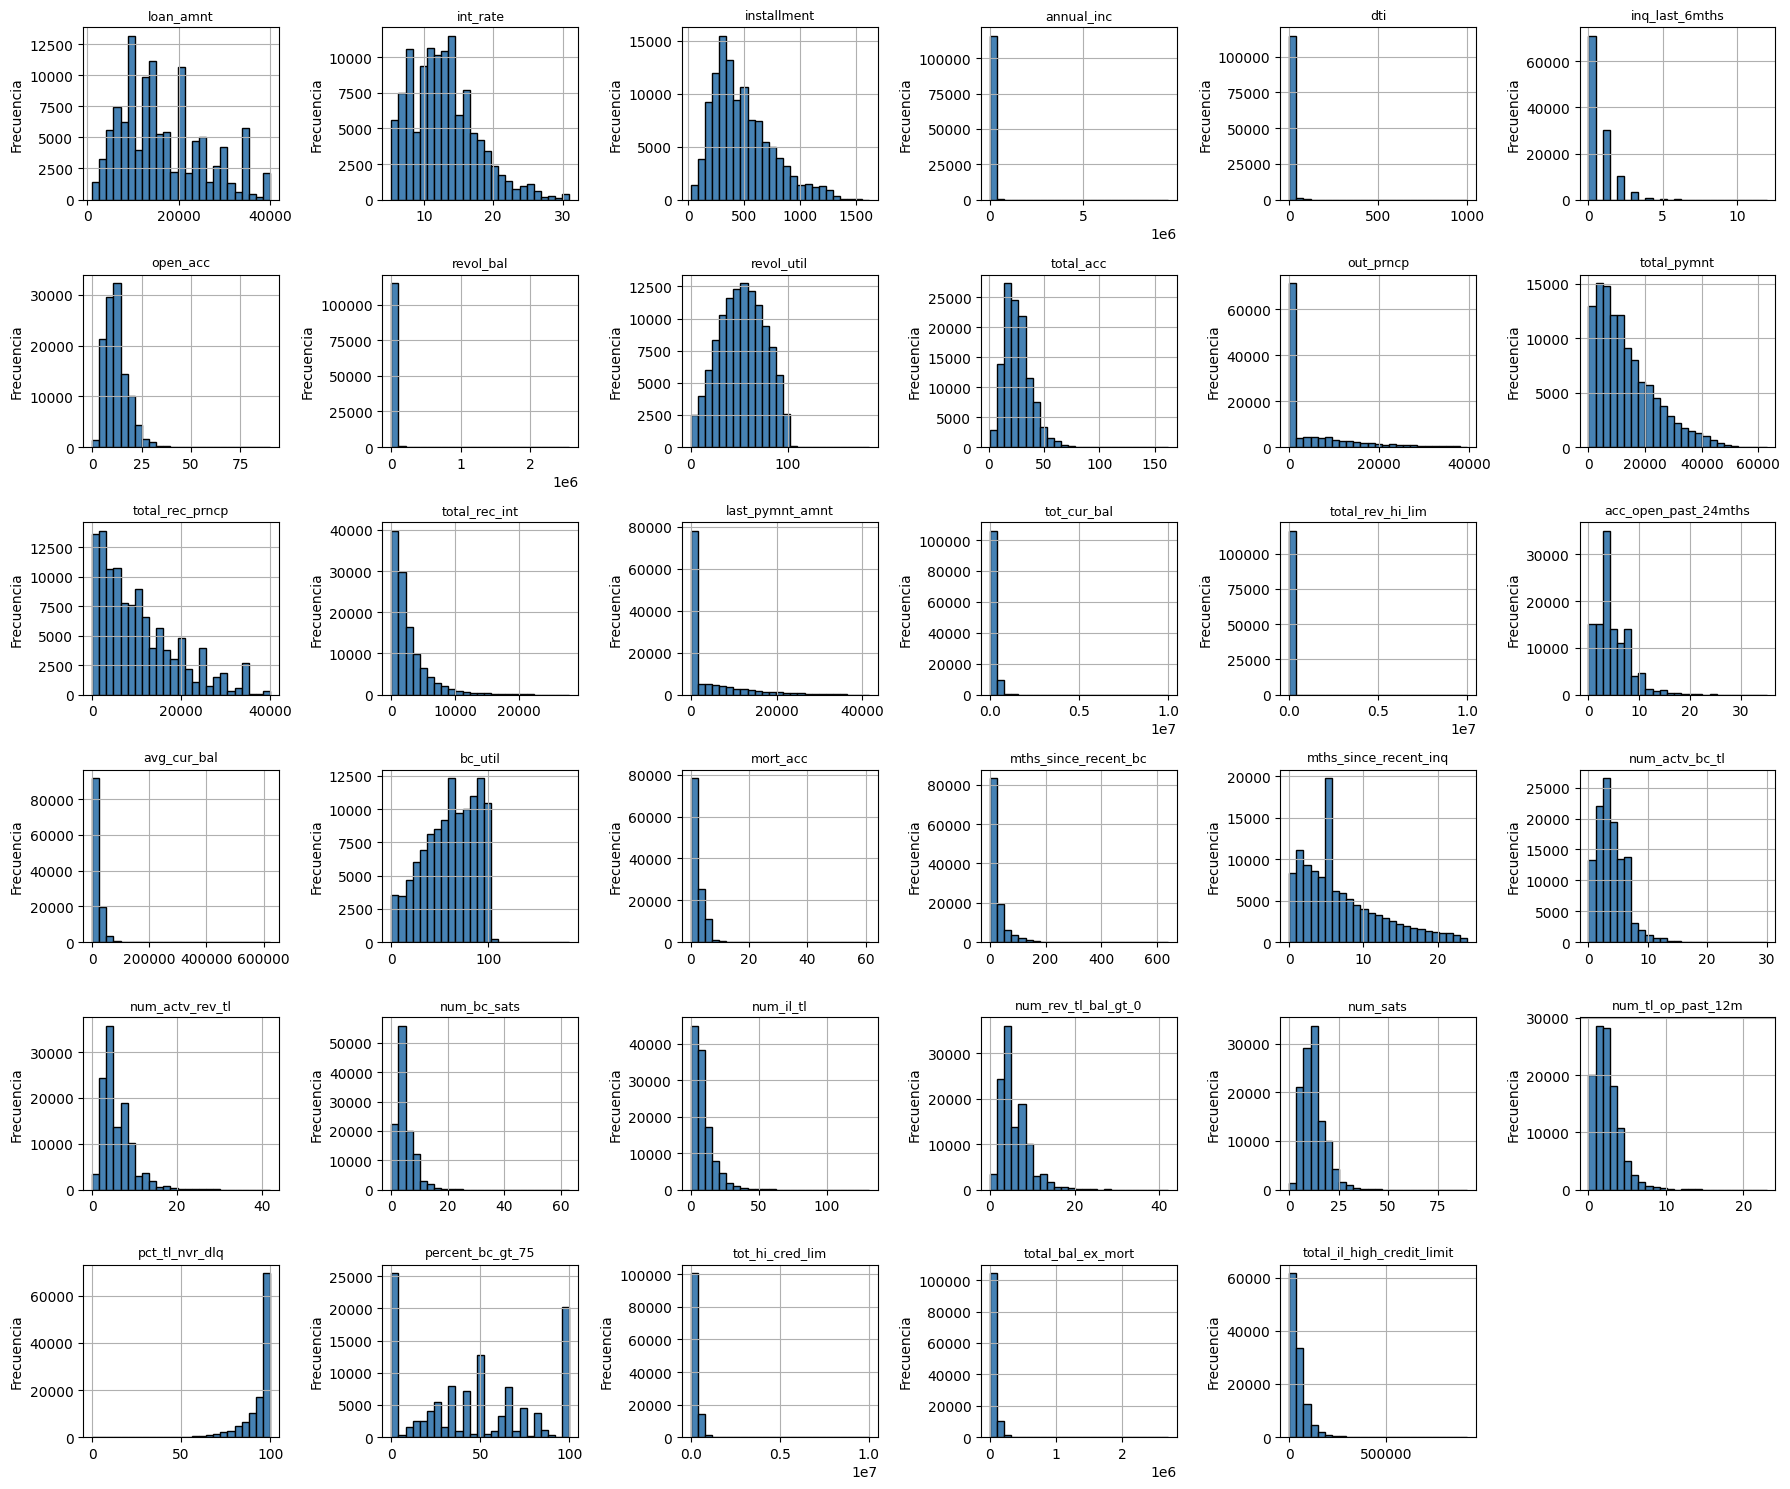

In [277]:
# Graficar histogramas variables numericas
df_pd = muestra_M.toPandas()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 15))  
axes = axes.flatten()


for i, col in enumerate(columnas_numericas_M):
    axes[i].hist(df_pd[col].dropna(), bins=25, color='steelblue', edgecolor='black')
    axes[i].set_title(f"{col}", fontsize=9)
    axes[i].set_xlabel("")  
    axes[i].set_ylabel("Frecuencia")
    axes[i].grid(True)

# Ocultar subplots vacíos si hay más ejes que columnas
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

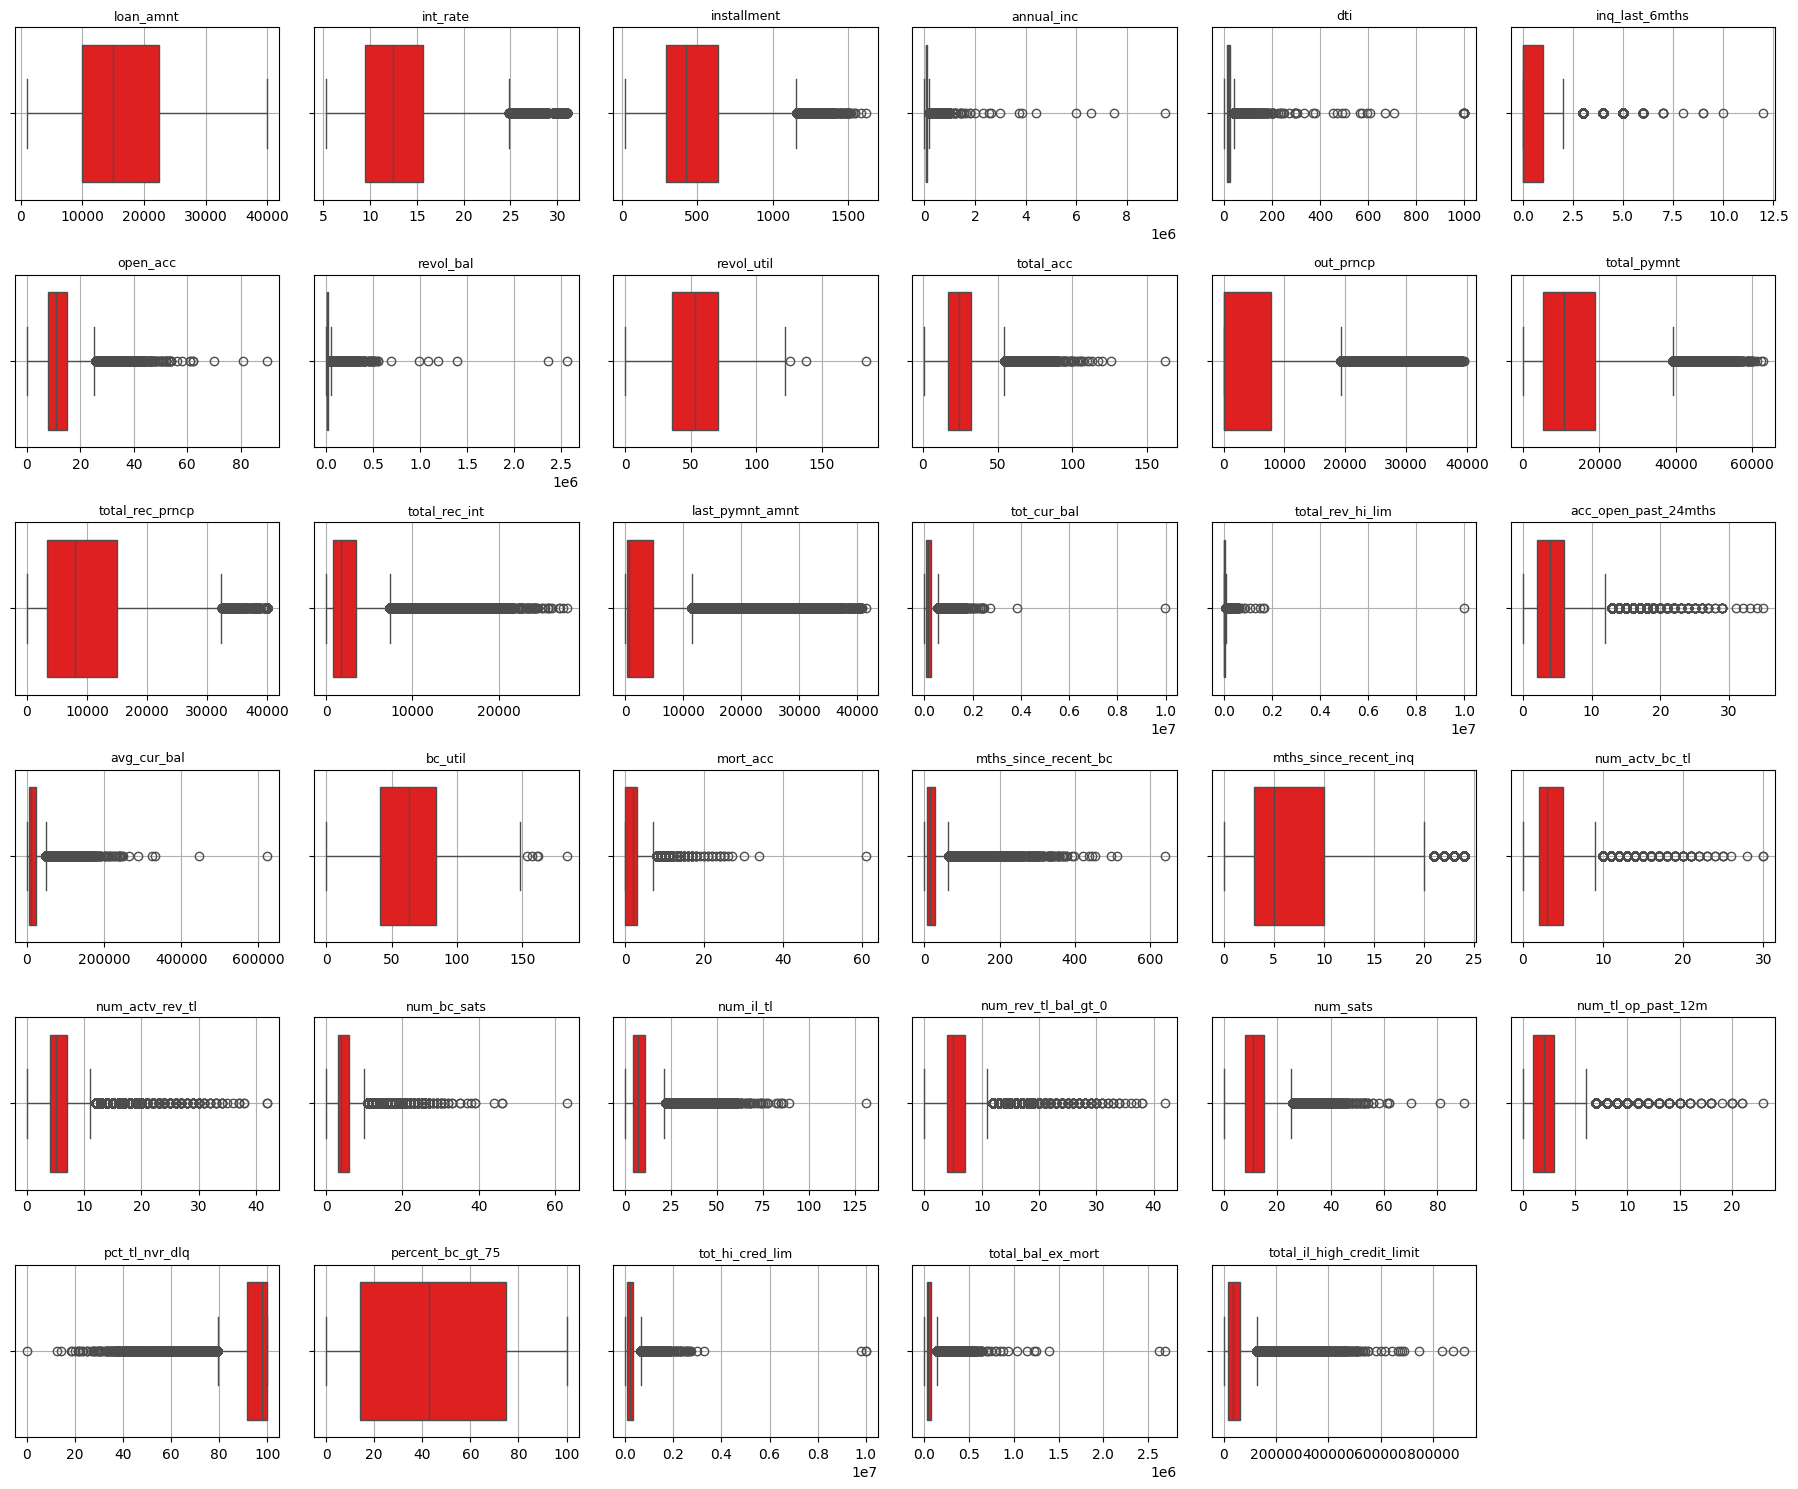

In [278]:
# Graficar boxplots de cada columna numérica

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 15)) 
axes = axes.flatten()

for i, col in enumerate(columnas_numericas_M):
    sns.boxplot(x=df_pd[col].dropna(), ax=axes[i], color="red")
    axes[i].set_title(f"{col}", fontsize=9)
    axes[i].set_xlabel("")
    axes[i].grid(True)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [279]:

py_round = __builtins__.round 

def eliminar_outliers_spark(df, columnas):
    for nombre_col in columnas:
        # Calcular Q1 y Q3
        q1, q3 = df.approxQuantile(nombre_col, [0.25, 0.75], 0.01)
        iqr = q3 - q1
        limite_inferior = q1 - 1.5 * iqr
        limite_superior = q3 + 1.5 * iqr

        # Filtrar fuera del IQR
        df = df.filter(
            (spark_col(nombre_col) >= limite_inferior) & (spark_col(nombre_col) <= limite_superior)
        )
        
    return df


In [280]:

muestra_M_limpia = eliminar_outliers_spark(muestra_M, columnas_numericas_M)


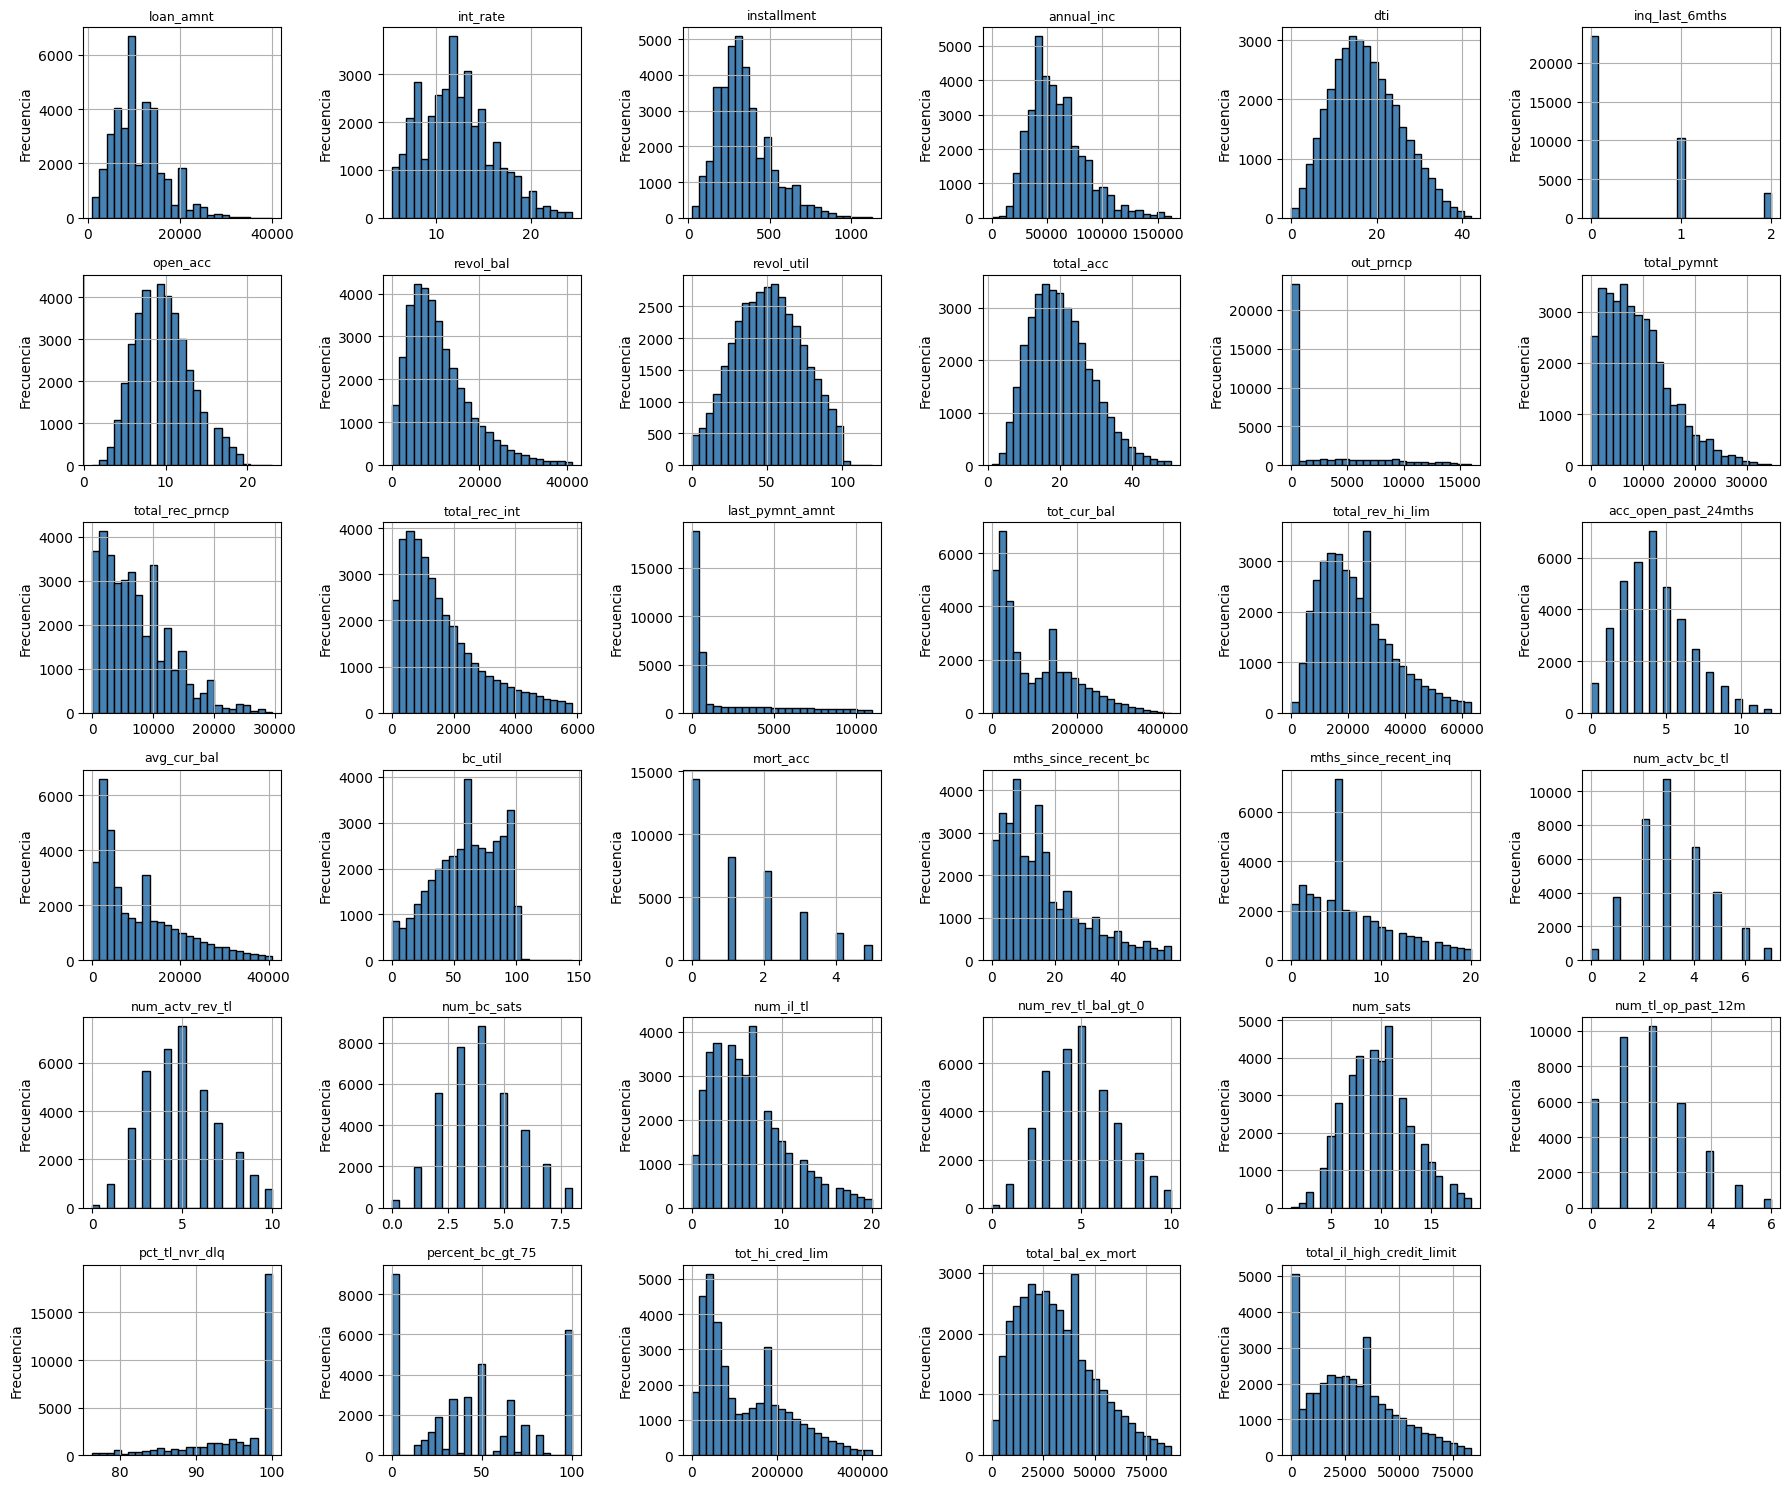

In [281]:
# Graficar histogramas variables numericas despues de eliminar outliers 
df_pd_M = muestra_M_limpia.toPandas()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 15))  
axes = axes.flatten()


for i, col in enumerate(columnas_numericas_M):
    axes[i].hist(df_pd_M[col].dropna(), bins=25, color='steelblue', edgecolor='black')
    axes[i].set_title(f"{col}", fontsize=9)
    axes[i].set_xlabel("")  
    axes[i].set_ylabel("Frecuencia")
    axes[i].grid(True)

# Ocultar subplots vacíos si hay más ejes que columnas
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

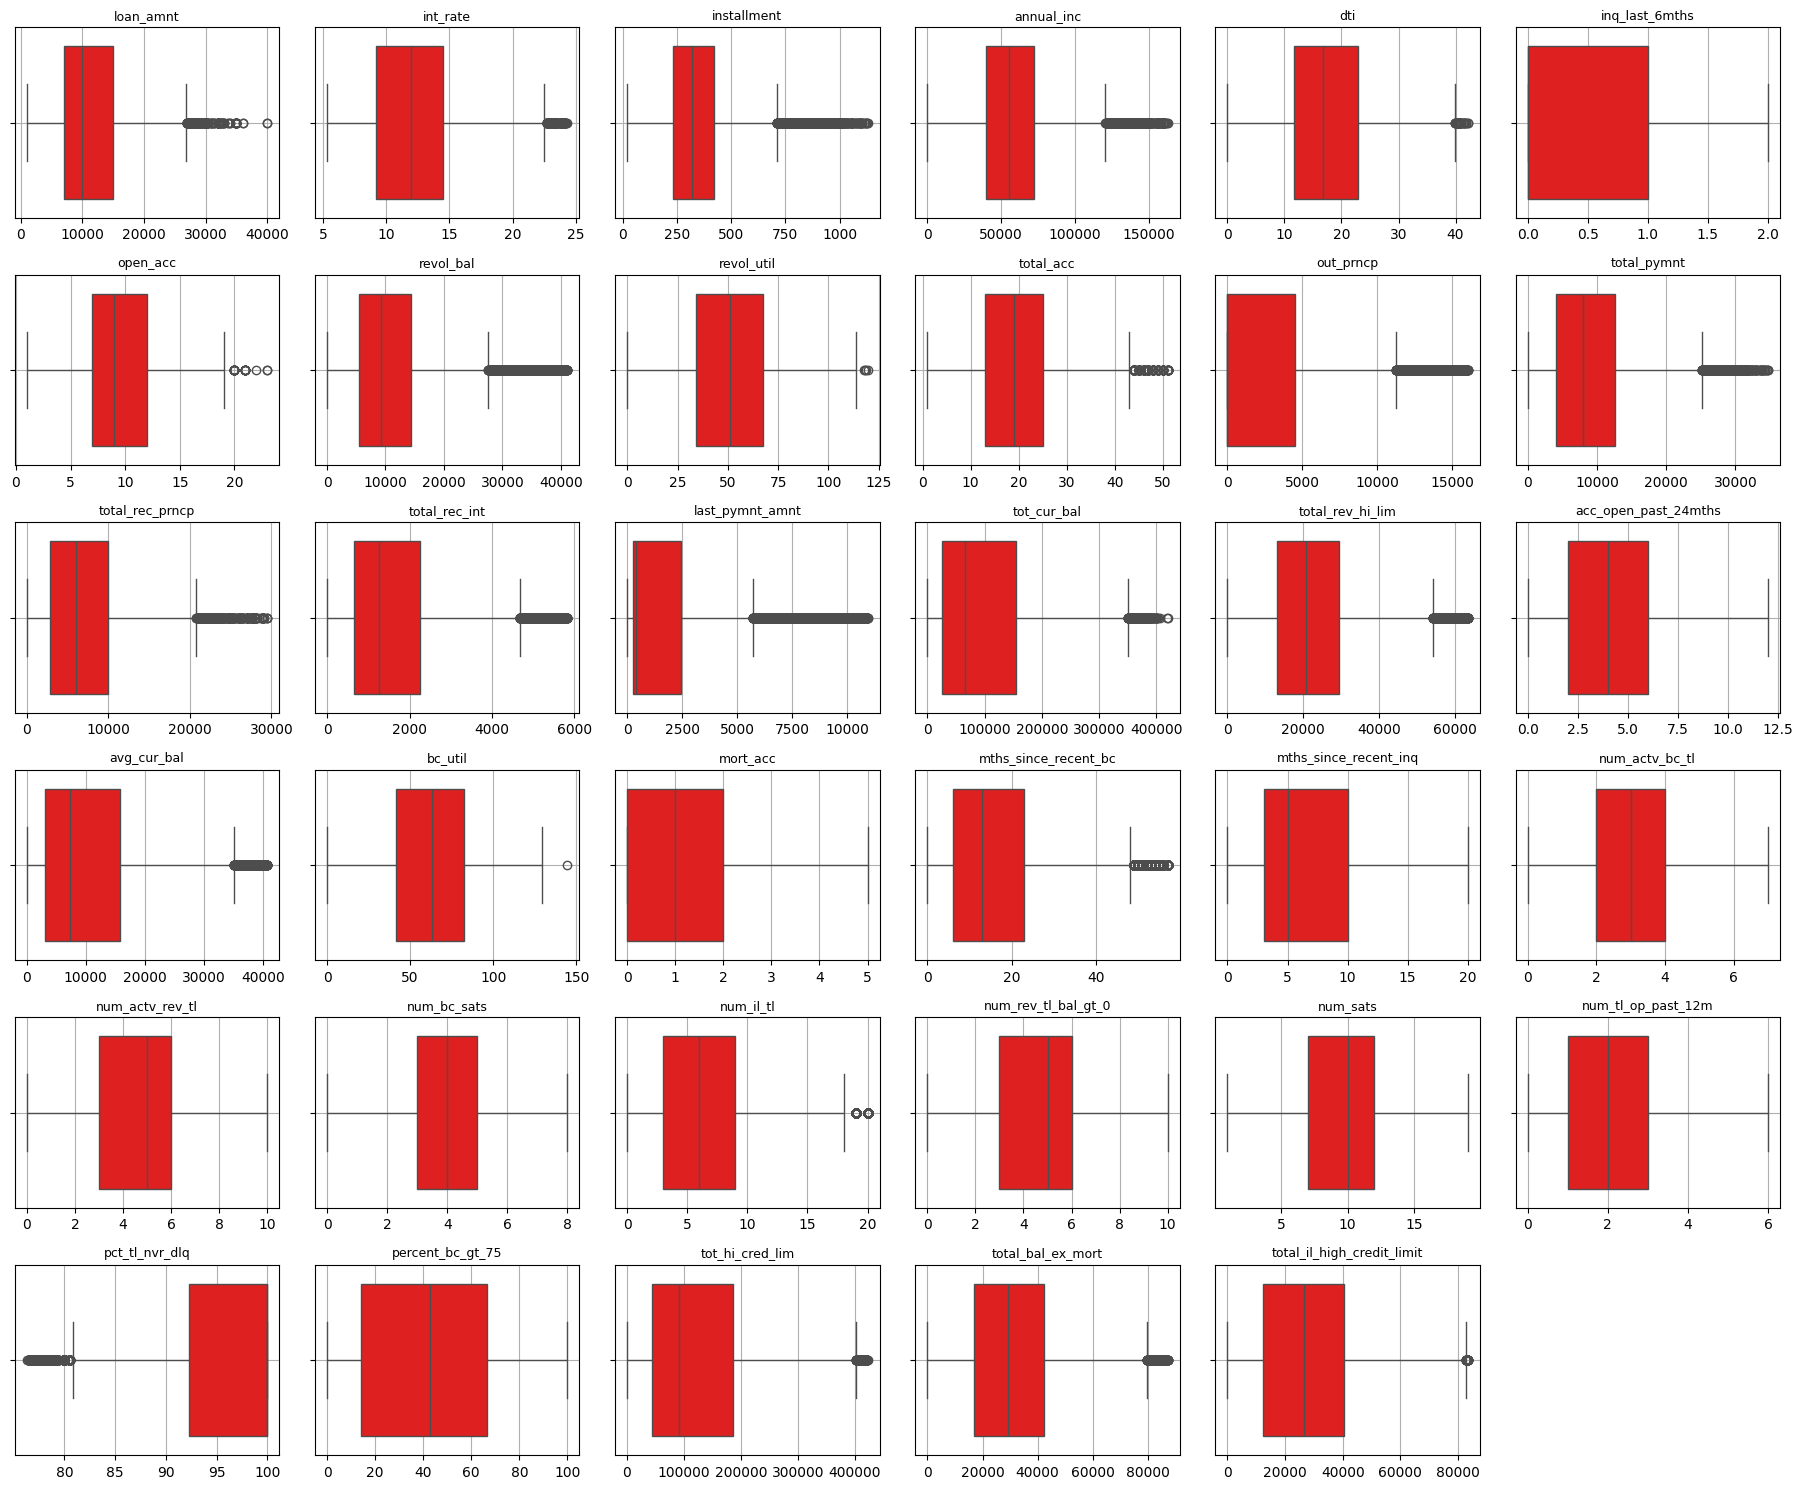

In [282]:
# Graficar boxplots de cada columna numérica

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 15)) 
axes = axes.flatten()

for i, col in enumerate(columnas_numericas_M):
    sns.boxplot(x=df_pd_M[col].dropna(), ax=axes[i], color="red")
    axes[i].set_title(f"{col}", fontsize=9)
    axes[i].set_xlabel("")
    axes[i].grid(True)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

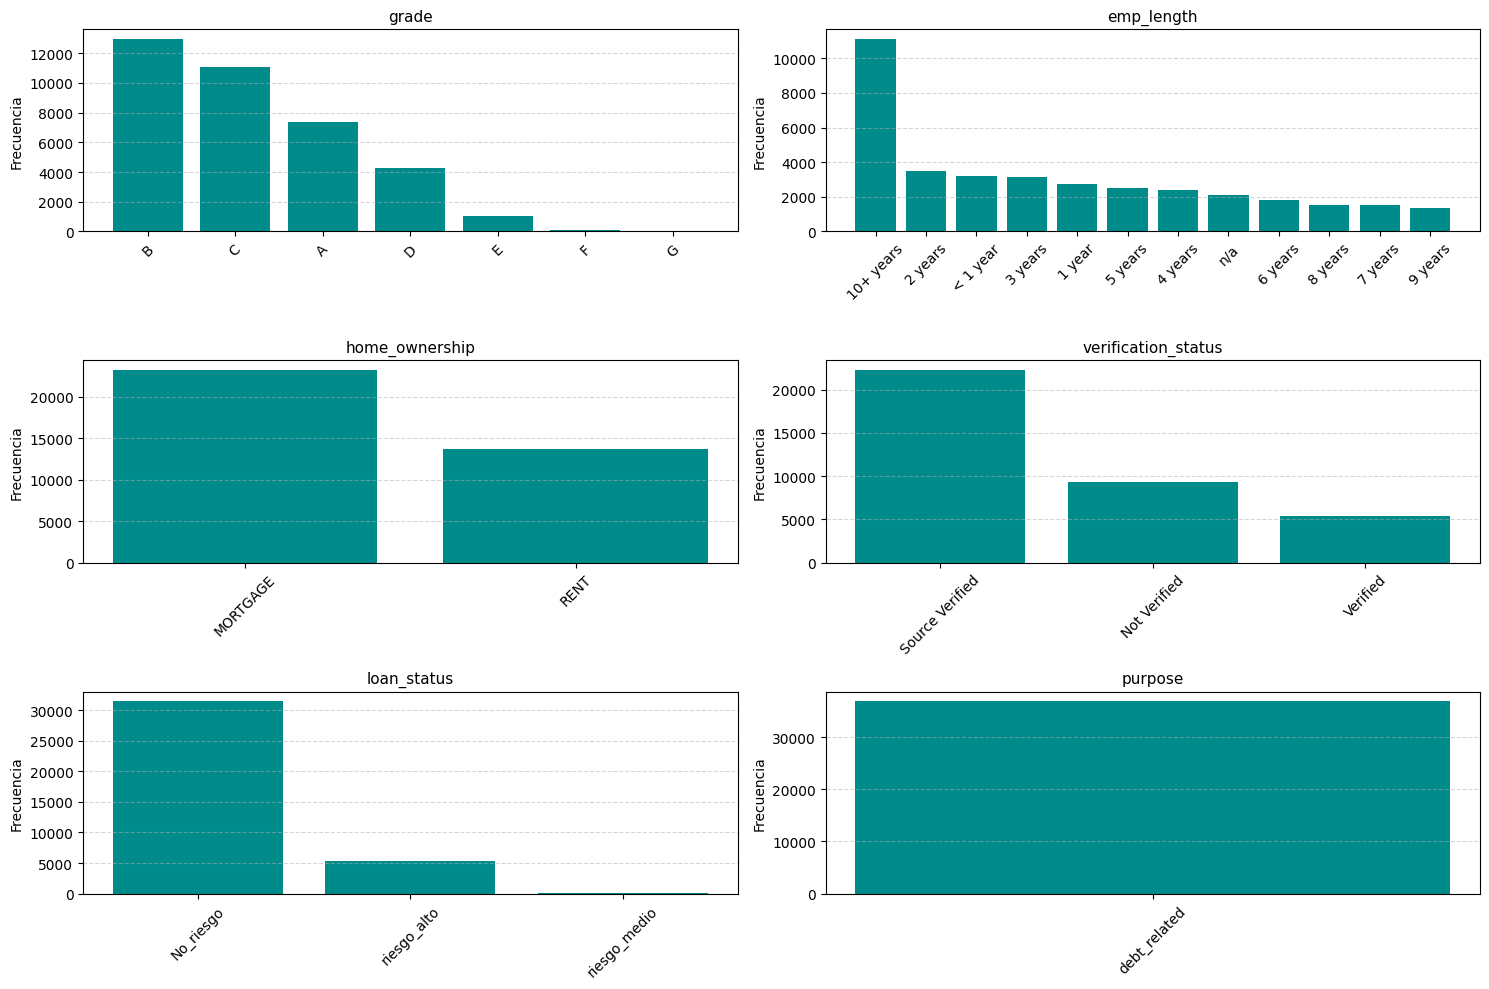

In [283]:

df_cat = muestra_M_limpia.select(columnas_categoricas_M).toPandas()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# Graficar cada variable categórica
for i, col in enumerate(columnas_categoricas):
    conteo = df_cat[col].value_counts().sort_values(ascending=False)
    axes[i].bar(conteo.index, conteo.values, color='darkcyan')
    axes[i].set_title(f"{col}", fontsize=11)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel("Frecuencia")
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

# Eliminar ejes sobrantes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [284]:
muestra_M_limpia = muestra_M_limpia.drop("purpose")


In [285]:
# Nueva columna binaria: riesgo_alto = 1, No_riesgo  = 0
muestra_M_limpia = muestra_M_limpia.withColumn(
    "loan_status",
    F.when(F.col("loan_status") == "riesgo_alto", 1).otherwise(0)
)


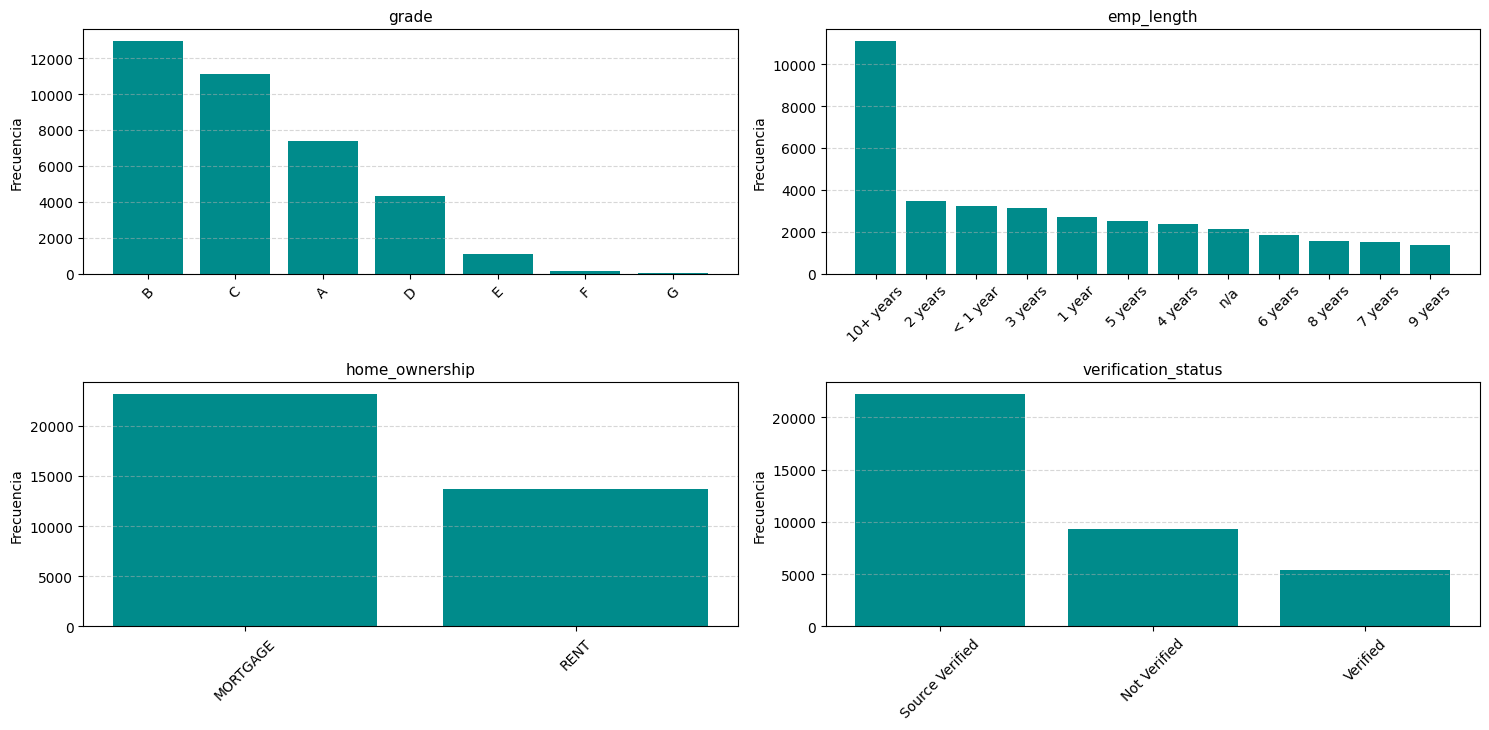

In [286]:
columnas_categoricas_M_l = [c for c, t in muestra_M_limpia.dtypes if t == "string"]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# Graficar cada variable categórica
for i, col in enumerate(columnas_categoricas_M_l):
    conteo = df_cat[col].value_counts().sort_values(ascending=False)
    axes[i].bar(conteo.index, conteo.values, color='darkcyan')
    axes[i].set_title(f"{col}", fontsize=11)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel("Frecuencia")
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

# Eliminar ejes sobrantes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [287]:
columnas_categoricas = ["grade", "emp_length", "home_ownership", "verification_status"]


In [288]:
from pyspark.ml.feature import StringIndexer
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep")
    for c in columnas_categoricas
]

In [289]:
pipeline_indexado = Pipeline(stages=indexers)
datos = pipeline_indexado.fit(muestra_M_limpia).transform(muestra_M_limpia)

In [290]:
datos = datos.drop(*columnas_categoricas)


In [291]:
datos.show()

+---------+--------+-----------+----------+-----------+-----+--------------+--------+---------+----------+---------+---------+--------------+---------------+-------------+---------------+-----------+----------------+--------------------+-----------+-------+--------+--------------------+---------------------+--------------+---------------+-----------+---------+-------------------+--------+------------------+--------------+----------------+---------------+-----------------+--------------------------+-----------+----------------+--------------------+-------------------------+
|loan_amnt|int_rate|installment|annual_inc|loan_status|  dti|inq_last_6mths|open_acc|revol_bal|revol_util|total_acc|out_prncp|   total_pymnt|total_rec_prncp|total_rec_int|last_pymnt_amnt|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|bc_util|mort_acc|mths_since_recent_bc|mths_since_recent_inq|num_actv_bc_tl|num_actv_rev_tl|num_bc_sats|num_il_tl|num_rev_tl_bal_gt_0|num_sats|num_tl_op_past_12m|pct_tl_nvr

In [292]:
datos.groupBy('loan_status').count().orderBy("count", ascending=False).show()

+-----------+-----+
|loan_status|count|
+-----------+-----+
|          0|31630|
|          1| 5294|
+-----------+-----+



# **4. Preparación del conjunto de entrenamiento y prueba**

Una vez que los datos fueron completamente limpiados, transformados y preprocesados (imputación, tratamiento de valores atípicos y tipificación de variables), se procedió a dividir el conjunto `muestra_M` en dos subconjuntos:

- **Conjunto de entrenamiento (train_data)**: 80% de los datos, utilizado para ajustar los modelos.
- **Conjunto de prueba (test_data)**: 20% restante, utilizado para evaluar el desempeño de los modelos sobre datos no vistos.

La división se realizó utilizando el método `randomSplit()` de PySpark, con una semilla fija (`seed=1`) para asegurar la reproducibilidad del experimento.

Esta división permitirá aplicar tanto modelos supervisados como no supervisados en los siguientes pasos.


In [293]:
# Dividir en 80% entrenamiento, 20% prueba
train_data, test_data = datos.randomSplit([0.8, 0.2], seed=1)

# Confirmar cantidad de registros
print(f"Registros en entrenamiento: {train_data.count()}")
print(f"Registros en prueba: {test_data.count()}")


Registros en entrenamiento: 29465
Registros en prueba: 7459


# **5. Construcción de modelos de aprendizaje supervisado y no supervisado**

En esta sección se implementan dos experimentos distintos de aprendizaje automático utilizando PySpark:

- Un modelo de **aprendizaje supervisado**, donde se entrena un clasificador con una variable objetivo conocida (`loan_status`), y
- Un modelo de **aprendizaje no supervisado**, donde se aplican algoritmos de agrupamiento sin tener etiquetas previas.

Ambos modelos se entrenan y evalúan utilizando la muestra depurada `muestra_M_limpia`, dividida previamente en conjuntos de entrenamiento y prueba.

## 5.1 Modelo Supervisado

Para el aprendizaje supervisado se seleccionó el algoritmo `RandomForestClassifier`, el cual es adecuado para tareas de clasificación binaria y maneja bien variables tanto numéricas como categóricas. La variable objetivo es `loan_status`, donde se clasifican los registros como de **riesgo alto** (`1`) o **no riesgo** (`0`).

Se utilizaron las siguientes etapas:

1. **Vectorización de características**: se agruparon todas las variables predictoras en un único vector (`features`) usando `VectorAssembler`.
2. **Entrenamiento del modelo**: se entrenó el modelo con el conjunto de entrenamiento.
3. **Predicciones**: se generaron predicciones sobre el conjunto de prueba.
4. **Evaluación del desempeño**: se calculó la métrica de exactitud (`accuracy`) como medida principal, y se complementó con otras métricas como `precision`, `recall` y `f1-score`.


In [309]:
# Separar clases
minority_class = train_data.filter(F.col("loan_status") == 1)
majority_class = train_data.filter(F.col("loan_status") == 0)

# Oversample minoría (duplicar o triplicar)
oversampled_minority = minority_class.sample(withReplacement=True, fraction=2.0, seed=42)

# Unir ambos
df_balanced = majority_class.unionAll(oversampled_minority)


In [310]:
# Variables predictoras
X = df_balanced.drop('loan_status').columns

# Variable objetivo
Y = "loan_status"

In [ ]:
# Ensamblar características en un vector
assembler = VectorAssembler(
    inputCols=X,
    outputCol="features"
)


In [312]:

# Clasificador Random Forest
rf = RandomForestClassifier(
    labelCol=Y,
    featuresCol="features",
    numTrees=50,
    maxDepth=5,
    seed=1
)

# Pipeline
pipeline = Pipeline(stages=[assembler, rf])

In [315]:
# Entrenamiento
modelo_rf = pipeline.fit(df_balanced)

# Predicciones en conjunto de prueba
predicciones_rf = modelo_rf.transform(test_data)

In [316]:
# Evaluador de clasificación
evaluator = MulticlassClassificationEvaluator(
    labelCol=Y,
    predictionCol="prediction",
    metricName="accuracy"
)

# Calcular exactitud
accuracy = evaluator.evaluate(predicciones_rf)
print(f"Exactitud del modelo Random Forest: {accuracy:.4f}")


Exactitud del modelo Random Forest: 0.9559


In [317]:
for metric in ["accuracy", "weightedPrecision", "weightedRecall", "f1"]:
    evaluator.setMetricName(metric)
    score = evaluator.evaluate(predicciones_rf)
    print(f"{metric.capitalize()}: {score:.4f}")


Accuracy: 0.9559
Weightedprecision: 0.9572
Weightedrecall: 0.9559
F1: 0.9526


In [318]:
from pyspark.sql.functions import col

conteo = predicciones_rf.groupBy("loan_status", "prediction").count()
conteo.orderBy(col("loan_status"), col("prediction")).show()


+-----------+----------+-----+
|loan_status|prediction|count|
+-----------+----------+-----+
|          0|       0.0| 6397|
|          0|       1.0|   11|
|          1|       0.0|  318|
|          1|       1.0|  733|
+-----------+----------+-----+



In [307]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="loan_status", rawPredictionCol="rawPrediction")
auc = evaluator.evaluate(predicciones_rf)
print(f"AUC-ROC: {auc:.4f}")


AUC-ROC: 0.9668


## 5.2 Modelo No Supervisado

Para el enfoque no supervisado se seleccionó un algoritmo de agrupamiento para explorar patrones ocultos en los datos sin una variable objetivo definida. En este caso se utilizó el algoritmo **KMeans**, uno de los más conocidos para tareas de clustering.

Se llevaron a cabo las siguientes etapas:

1. **Selección de características**: se eligieron las variables que fueron previamente limpiadas y transformadas. Se excluye la avariables objetivo como `loan_status`.
2. **Vectorización de características**: se agruparon las variables predictoras en un solo vector usando `VectorAssembler`, creando la columna `features`.
3. **Construcción del modelo**: se utilizó `KMeans` con un valor de `k=2` para generar tres clústeres, lo cual se puede interpretar como una forma de segmentar perfiles de clientes en función de características financieras.
4. **Entrenamiento y predicción**: el modelo fue entrenado con los datos de entrada y se obtuvieron las predicciones asignando un número de clúster a cada registro.
5. **Evaluación del desempeño**: se utilizó la métrica `silhouette score` para evaluar la calidad del agrupamiento, midiendo qué tan bien se separan los clústeres.



In [319]:
# Variables predictoras
X = df_balanced.drop('loan_status').columns
# Confirmar columnas seleccionadas
print("Columnas para clustering:", X)

Columnas para clustering: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_util', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_il_tl', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_il_high_credit_limit', 'grade_index', 'emp_length_index', 'home_ownership_index', 'verification_status_index']


In [321]:
# Ensamblar características en un vector
assembler = VectorAssembler(
    inputCols=X,
    outputCol="features"
)
vector_df = assembler.transform(df_balanced)

In [ ]:
from pyspark.ml.clustering import KMeans

# Crear modelo KMeans con k=2
kmeans = KMeans(featuresCol="features", k=2, seed=1)

# Entrenar modelo
modelo_kmeans = kmeans.fit(vector_df)

# Predecir clúster para cada registro
predicciones_kmeans = modelo_kmeans.transform(vector_df)

# Ver resultados
predicciones_kmeans.select("prediction").show(10)


+----------+
|prediction|
+----------+
|         1|
|         0|
|         1|
|         1|
|         1|
|         0|
|         1|
|         1|
|         1|
|         0|
+----------+
only showing top 10 rows



In [323]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluador Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")

# Calcular puntuación
silhouette = evaluator.evaluate(predicciones_kmeans)
print(f"Silhouette Score: {silhouette:.4f}")


Silhouette Score: 0.7675


In [324]:
predicciones_kmeans.select("prediction", "loan_status").groupBy("prediction", "loan_status",).count().show()


+----------+-----------+-----+
|prediction|loan_status|count|
+----------+-----------+-----+
|         1|          0|10167|
|         0|          0|15055|
|         0|          1| 5525|
|         1|          1| 2877|
+----------+-----------+-----+



# **Conclusión General del Análisis**

Durante el desarrollo del proyecto se abordaron técnicas de aprendizaje supervisado y no supervisado sobre un conjunto de datos financieros, aplicando una preparación rigurosa y análisis detallado.

**1. Preparación y limpieza de datos:**
- Se identificaron y eliminaron valores nulos y atípicos.
- Se transformaron variables categóricas con `StringIndexer` para su procesamiento.
- Se balancearon las clases en el conjunto de entrenamiento para mitigar el sesgo hacia la clase mayoritaria.

**2. Modelo Supervisado (Random Forest):**
- Se utilizó RandomForestClassifier por su capacidad de manejar variables numéricas y categóricas.
- Se obtuvo una alta precisión de **95.5%**, con métricas de:
  - **Precision ponderada:** 95.7%
  - **Recall ponderado:** 95.5%
  - **F1-score:** 95.2%
- El modelo mostró un buen rendimiento general, siendo eficaz en la clasificación del riesgo de crédito (`loan_status`).

**3. Modelo No Supervisado (KMeans):**
- Se aplicó el algoritmo KMeans con `k=2` para identificar patrones ocultos sin utilizar la variable objetivo.
- Se obtuvo un **Silhouette Score de 0.7675**, indicando una buena separación entre clústeres.
- Al comparar con la variable `loan_status`, se observó una relación razonable entre los grupos generados y las clases reales.

**4. Observaciones:**
- El modelo supervisado resultó altamente efectivo para clasificación directa.
- El modelo no supervisado fue útil para validar que existen agrupaciones naturales en los datos que se relacionan con el riesgo financiero.
- El balanceo de clases mejoró la capacidad del modelo para identificar correctamente casos de alto riesgo.

**5. Conclusión final:**
La combinación de técnicas supervisadas y no supervisadas permitió comprender mejor la estructura del conjunto de datos y construir un sistema robusto de predicción de riesgo crediticio. Se confirma que los atributos seleccionados contienen suficiente información discriminativa para ser utilizados en aplicaciones reales de análisis financiero.
